In [46]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from statsmodels.stats.weightstats import ttest_ind

In [47]:
con = sqlite3.connect(r'zippedData\im.db\im.db')

cur = con.cursor()

cur.execute("SELECT name from sqlite_master").fetchall()

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [48]:
combined = """SELECT *
                from principals
                JOIN movie_akas USING (movie_id)
                JOIN movie_basics USING (movie_id)
                JOIN movie_ratings USING (movie_id)
                JOIN persons USING (person_id);"""

combined_df = pd.read_sql_query(combined,con)
combined_df.head()

,movie_id,ordering,person_id,category,job,characters,ordering,title,region,language,...,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,primary_name,birth_year,death_year,primary_profession
0,tt0323808,10,nm0059247,editor,None,None,1,May Day,GB,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
1,tt0323808,10,nm0059247,editor,None,None,2,Cowboys for Christ,GB,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
2,tt0323808,10,nm0059247,editor,None,None,3,The Wicker Tree,GB,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
3,tt0323808,10,nm0059247,editor,None,None,4,The Wicker Tree,None,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
4,tt0323808,10,nm0059247,editor,None,None,5,Плетеное дерево,RU,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"


In [49]:
imdb_df = combined_df.copy()
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422866 entries, 0 to 2422865
Data columns (total 24 columns):
 #   Column              Dtype  
---  ------              -----  
 0   movie_id            object 
 1   ordering            int64  
 2   person_id           object 
 3   category            object 
 4   job                 object 
 5   characters          object 
 6   ordering            int64  
 7   title               object 
 8   region              object 
 9   language            object 
 10  types               object 
 11  attributes          object 
 12  is_original_title   float64
 13  primary_title       object 
 14  original_title      object 
 15  start_year          int64  
 16  runtime_minutes     float64
 17  genres              object 
 18  averagerating       float64
 19  numvotes            int64  
 20  primary_name        object 
 21  birth_year          float64
 22  death_year          float64
 23  primary_profession  object 
dtypes: float64(5), int64(4),

In [50]:
#dropping the columns with 40%+ null values
imdb_df.drop(labels=['death_year','attributes','language','job','characters','birth_year','types'],axis=1,inplace=True)

#checking columns with null values.
imdb_df.isna().mean()[imdb_df.isna().mean() > 0].sort_values(ascending=False)

region                0.162510
runtime_minutes       0.039211
primary_profession    0.021650
genres                0.003738
dtype: float64

In [51]:
columns_with_null_values = imdb_df.isna().mean()[imdb_df.isna().mean() > 0].index.tolist()
columns_with_null_values

#I will drop all the rows with null values since they are only a small percentage of the dataset.
imdb_df.dropna(axis=0,subset=columns_with_null_values,inplace=True)
#checking columns with null values.
imdb_df.isna().mean()[imdb_df.isna().mean() > 0].sort_values(ascending=False)

Series([], dtype: float64)

In [52]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909588 entries, 0 to 2422865
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   movie_id            object 
 1   ordering            int64  
 2   person_id           object 
 3   category            object 
 4   ordering            int64  
 5   title               object 
 6   region              object 
 7   is_original_title   float64
 8   primary_title       object 
 9   original_title      object 
 10  start_year          int64  
 11  runtime_minutes     float64
 12  genres              object 
 13  averagerating       float64
 14  numvotes            int64  
 15  primary_name        object 
 16  primary_profession  object 
dtypes: float64(3), int64(4), object(10)
memory usage: 262.2+ MB


In [53]:
tmdb_movies_df = pd.read_csv(r'zippedData\tmdb.movies.csv\tmdb.movies.csv')
tmdb_movies_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [54]:
movie_budgets_df = pd.read_csv(r'zippedData\tn.movie_budgets.csv\tn.movie_budgets.csv') #,on_bad_lines='skip'

movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [55]:
imdb_numbers_merge = pd.merge(imdb_df,movie_budgets_df,left_on='title',right_on='movie')
imdb_numbers_merge.head()

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title,...,averagerating,numvotes,primary_name,primary_profession,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0475290,10,nm0005683,cinematographer,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,6.3,111422,Roger Deakins,"cinematographer,camera_department,miscellaneous",22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
1,tt0475290,1,nm0000982,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,6.3,111422,Josh Brolin,"actor,producer,writer",22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
2,tt0475290,2,nm0000123,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,6.3,111422,George Clooney,"actor,producer,director",22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
3,tt0475290,3,nm2403277,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,6.3,111422,Alden Ehrenreich,"actor,soundtrack",22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
4,tt0475290,4,nm0000146,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,6.3,111422,Ralph Fiennes,"actor,director,soundtrack",22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"


In [56]:
imdb_numbers_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72390 entries, 0 to 72389
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            72390 non-null  object 
 1   ordering            72390 non-null  int64  
 2   person_id           72390 non-null  object 
 3   category            72390 non-null  object 
 4   ordering            72390 non-null  int64  
 5   title               72390 non-null  object 
 6   region              72390 non-null  object 
 7   is_original_title   72390 non-null  float64
 8   primary_title       72390 non-null  object 
 9   original_title      72390 non-null  object 
 10  start_year          72390 non-null  int64  
 11  runtime_minutes     72390 non-null  float64
 12  genres              72390 non-null  object 
 13  averagerating       72390 non-null  float64
 14  numvotes            72390 non-null  int64  
 15  primary_name        72390 non-null  object 
 16  prim

In [57]:
imdb_tmdb = pd.merge(imdb_df,tmdb_movies_df,on='title')
imdb_tmdb.head()

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title_x,...,primary_profession,Unnamed: 0,genre_ids,id,original_language,original_title_y,popularity,release_date,vote_average,vote_count
0,tt0323808,10,nm0059247,editor,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,"editor,editorial_department,assistant_director",5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25
1,tt0323808,1,nm3579312,actress,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,"actress,soundtrack",5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25
2,tt0323808,2,nm2694680,actor,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,actor,5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25
3,tt0323808,3,nm0574615,actor,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,"actor,soundtrack,director",5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25
4,tt0323808,4,nm0502652,actress,3,The Wicker Tree,GB,0.0,The Wicker Tree,The Wicker Tree,...,actress,5847,"[9648, 27, 53]",79544,en,The Wicker Tree,2.962,2012-01-27,4.4,25


In [58]:
imdb_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289507 entries, 0 to 289506
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movie_id            289507 non-null  object 
 1   ordering            289507 non-null  int64  
 2   person_id           289507 non-null  object 
 3   category            289507 non-null  object 
 4   ordering            289507 non-null  int64  
 5   title               289507 non-null  object 
 6   region              289507 non-null  object 
 7   is_original_title   289507 non-null  float64
 8   primary_title       289507 non-null  object 
 9   original_title_x    289507 non-null  object 
 10  start_year          289507 non-null  int64  
 11  runtime_minutes     289507 non-null  float64
 12  genres              289507 non-null  object 
 13  averagerating       289507 non-null  float64
 14  numvotes            289507 non-null  int64  
 15  primary_name        289507 non-nul

In [59]:
all_merge = pd.merge(imdb_tmdb,movie_budgets_df,left_on='title',right_on='movie')
all_merge.head()

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title_x,...,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,movie,production_budget,domestic_gross,worldwide_gross
0,tt0475290,10,nm0005683,cinematographer,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
1,tt0475290,1,nm0000982,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
2,tt0475290,2,nm0000123,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
3,tt0475290,3,nm2403277,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
4,tt0475290,4,nm0000146,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,12.312,2016-02-05,5.9,2328,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"


In [60]:
all_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84687 entries, 0 to 84686
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            84687 non-null  object 
 1   ordering            84687 non-null  int64  
 2   person_id           84687 non-null  object 
 3   category            84687 non-null  object 
 4   ordering            84687 non-null  int64  
 5   title               84687 non-null  object 
 6   region              84687 non-null  object 
 7   is_original_title   84687 non-null  float64
 8   primary_title       84687 non-null  object 
 9   original_title_x    84687 non-null  object 
 10  start_year          84687 non-null  int64  
 11  runtime_minutes     84687 non-null  float64
 12  genres              84687 non-null  object 
 13  averagerating       84687 non-null  float64
 14  numvotes            84687 non-null  int64  
 15  primary_name        84687 non-null  object 
 16  prim

In [61]:
all_merge[all_merge.duplicated() == True]

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title_x,...,popularity,release_date_x,vote_average,vote_count,id_y,release_date_y,movie,production_budget,domestic_gross,worldwide_gross


In [62]:
all_merge.isna().any()[all_merge.isna().any() == True]

Series([], dtype: bool)

In [63]:
all_merge.isna().any() == True

movie_id              False
ordering              False
person_id             False
category              False
ordering              False
title                 False
region                False
is_original_title     False
primary_title         False
original_title_x      False
start_year            False
runtime_minutes       False
genres                False
averagerating         False
numvotes              False
primary_name          False
primary_profession    False
Unnamed: 0            False
genre_ids             False
id_x                  False
original_language     False
original_title_y      False
popularity            False
release_date_x        False
vote_average          False
vote_count            False
id_y                  False
release_date_y        False
movie                 False
production_budget     False
domestic_gross        False
worldwide_gross       False
dtype: bool

In [64]:
tmdb_movies_df.isna().any()

Unnamed: 0           False
genre_ids            False
id                   False
original_language    False
original_title       False
popularity           False
release_date         False
title                False
vote_average         False
vote_count           False
dtype: bool

In [65]:
movie_budgets_df.isna().any()

id                   False
release_date         False
movie                False
production_budget    False
domestic_gross       False
worldwide_gross      False
dtype: bool

In [66]:
all_combined = all_merge

In [67]:
all_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'Unnamed: 0', 'genre_ids', 'id_x',
       'original_language', 'original_title_y', 'popularity', 'release_date_x',
       'vote_average', 'vote_count', 'id_y', 'release_date_y', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [68]:
all_combined['worldwide_gross'] = all_combined['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)
all_combined['domestic_gross'] = all_combined['domestic_gross'].replace('[\$,]', '', regex=True).astype(float)
all_combined['production_budget'] = all_combined['production_budget'].replace('[\$,]', '', regex=True).astype(float)


In [69]:
#creating a profit column worldwide_gross - production_budget
all_combined['profits'] = all_combined['worldwide_gross'] - all_combined['production_budget']
all_combined[['profits','worldwide_gross','production_budget']].head()

,profits,worldwide_gross,production_budget
0,42160680.0,64160680.0,22000000.0
1,42160680.0,64160680.0,22000000.0
2,42160680.0,64160680.0,22000000.0
3,42160680.0,64160680.0,22000000.0
4,42160680.0,64160680.0,22000000.0


In [70]:
all_merge.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'Unnamed: 0', 'genre_ids', 'id_x',
       'original_language', 'original_title_y', 'popularity', 'release_date_x',
       'vote_average', 'vote_count', 'id_y', 'release_date_y', 'movie',
       'production_budget', 'domestic_gross', 'worldwide_gross', 'profits'],
      dtype='object')

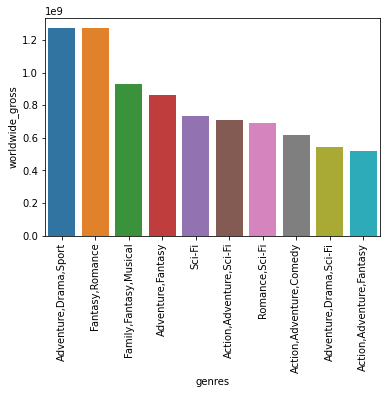

In [71]:
genre_groupby_pop = all_combined.groupby('genres').mean().sort_values('worldwide_gross',ascending=False).head(10)
genre_groupby_pop_top20 = genre_groupby_pop['worldwide_gross'].head(10)
xticks = genre_groupby_pop_top20.index
genre_groupby_pop_top20

genre_groupby_pop
# fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=genre_groupby_pop,x=genre_groupby_pop.index,y='worldwide_gross')
plt.xticks(rotation=90);


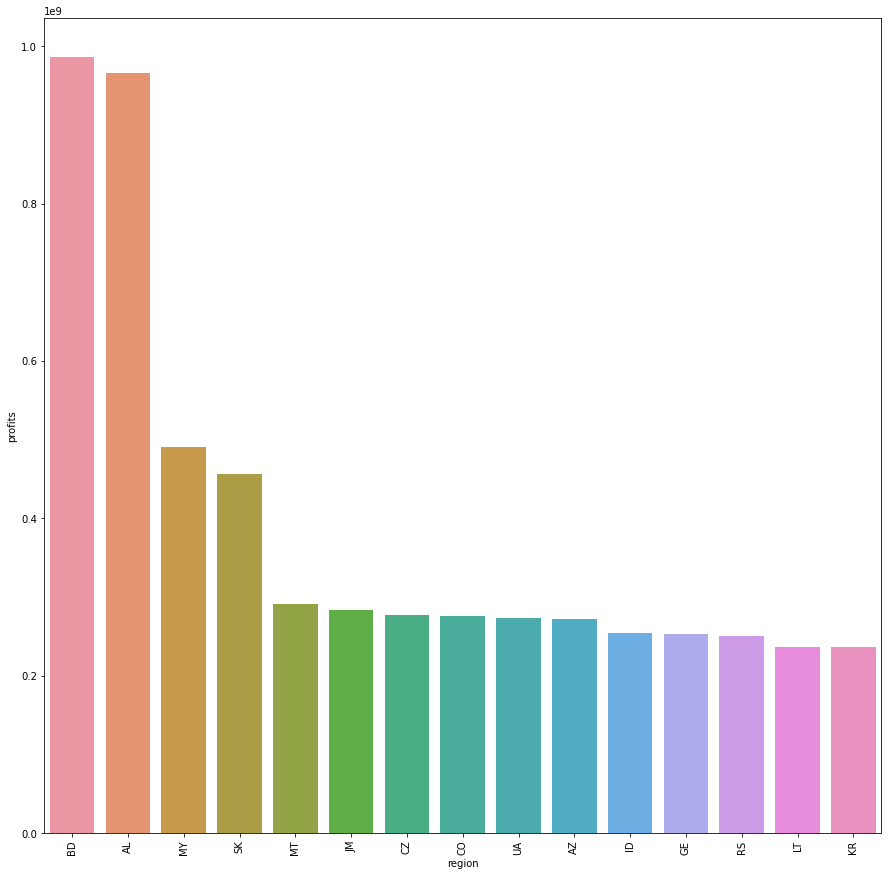

In [72]:
#group by region and find profits per region
region_groupby = all_combined.groupby('region').mean().sort_values('profits',ascending=False)
top_15_profits_regions = region_groupby.head(15)

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=top_15_profits_regions,x=top_15_profits_regions.index,y='profits')
plt.xticks(rotation=90);

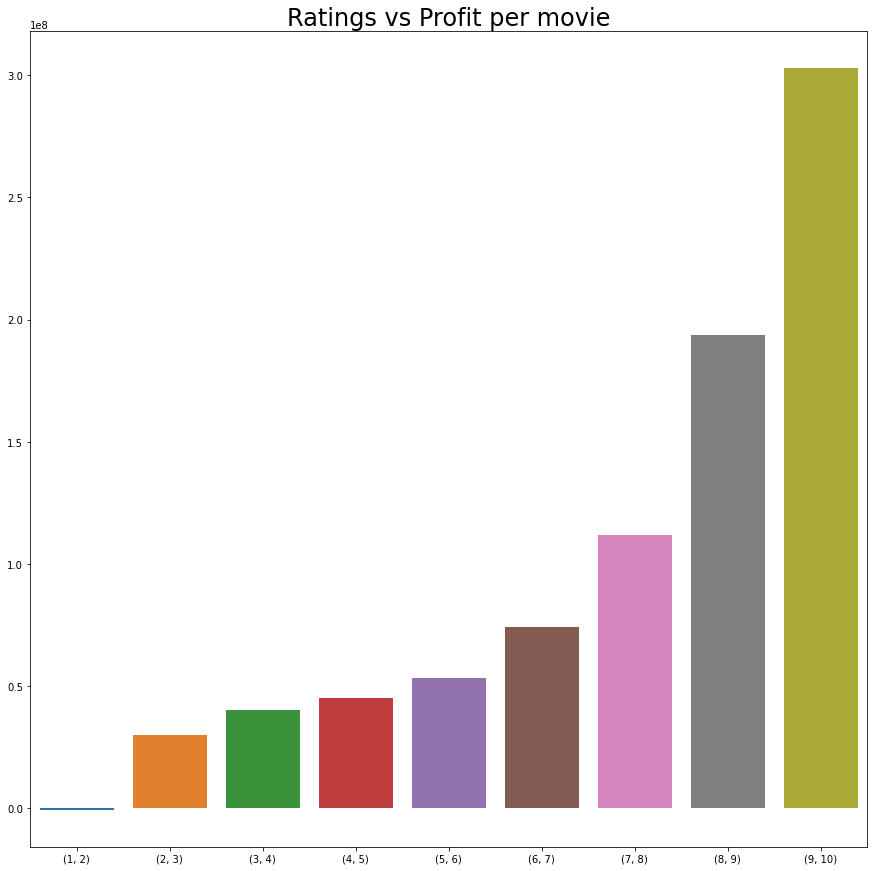

In [73]:
#group by averagerating vs profits per movie
#im gonna create bins for the ratings 1,2,3,4 to 10 
#then im gonna group by these bins plot binned ratings vs profits

rating_bins = [1,2,3,4,5,6,7,8,9,10]

all_combined['rating_bins'] = pd.cut(all_combined['averagerating'],bins=[0,1,2,3,4,5,6,7,8,9,10])


ratings_profits_sum = all_combined.groupby('rating_bins').sum().sort_values('profits',ascending=False)
ratings_movies_count = all_combined.groupby('rating_bins').count().sort_values('profits',ascending=False)
ratings_movie_numbers = ratings_movies_count['movie_id']

ratings_profits_per_movie = (ratings_profits_sum['profits']/ ratings_movie_numbers).dropna() #no movies rated 0-1 in df so there would be NA
ratings_profits_per_movie


rating_ranges=  [(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)]

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=ratings_profits_per_movie,x=ratings_profits_per_movie.index,y=ratings_profits_per_movie.values,)
ax.set_xticklabels(rating_ranges)
ax.set_title('Ratings vs Profit per movie',fontdict={'fontsize':24});



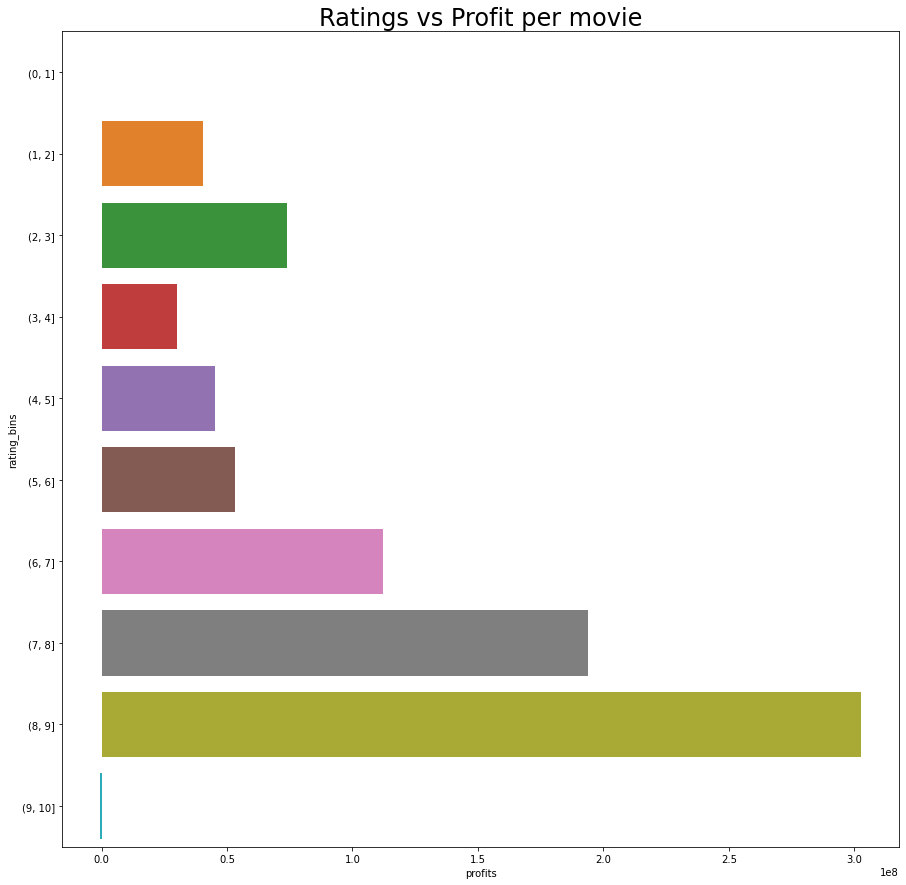

In [74]:
#group by averagerating vs profits per movie
#im gonna create bins for the ratings 1,2,3,4 to 10 
#then im gonna group by these bins plot binned ratings vs profits

rating_bins = [1,2,3,4,5,6,7,8,9,10]

all_combined['rating_bins'] = pd.cut(all_combined['averagerating'],bins=[0,1,2,3,4,5,6,7,8,9,10])


ratings_mean_profits = (all_combined.groupby('rating_bins').mean().sort_values('profits',ascending=False)).dropna()
ratings_mean_profits
# ratings_movies_count = all_combined.groupby('rating_bins').count().sort_values('profits',ascending=False)
# ratings_movie_numbers = ratings_movies_count['movie_id']

# ratings_profits_per_movie = (ratings_profits_sum['profits']/ ratings_movie_numbers).dropna() #no movies rated 0-1 in df so there would be NA
# ratings_profits_per_movie


# rating_ranges=  [(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)]

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=ratings_mean_profits,y=ratings_mean_profits.index,x='profits')
# # ax.set_xticklabels(rating_ranges)
ax.set_title('Ratings vs Profit per movie',fontdict={'fontsize':24});

Text(0.5, 1.0, 'Top 20 Directors ranked by average profit')

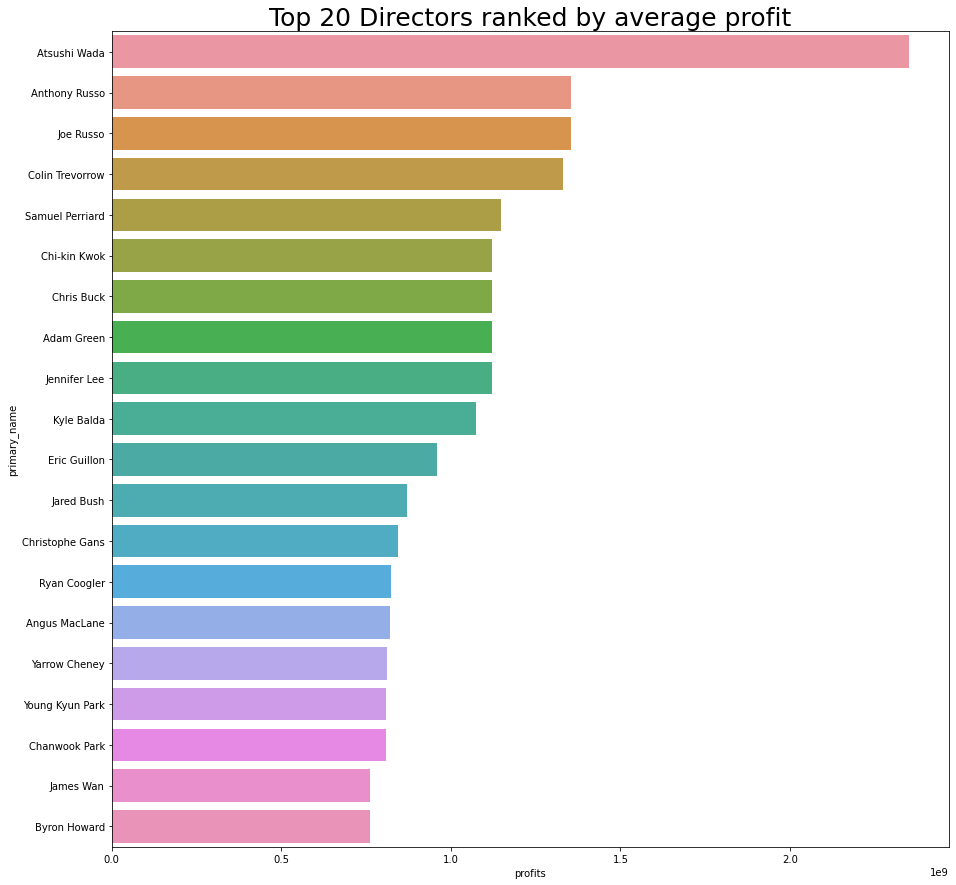

In [75]:
#average profits per director
directors_id_groupby = all_combined[all_combined['category'] == 'director'].groupby('primary_name').mean().sort_values('profits',ascending=False)
top_20_directors_by_profit = directors_id_groupby.head(20)
top_20_directors_by_profit

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data = top_20_directors_by_profit,x='profits',y=top_20_directors_by_profit.index)
ax.set_title('Top 20 Directors ranked by average profit',fontdict={'fontsize':25})


Text(0.5, 1.0, 'Top 30 Actors ranked by average profit')

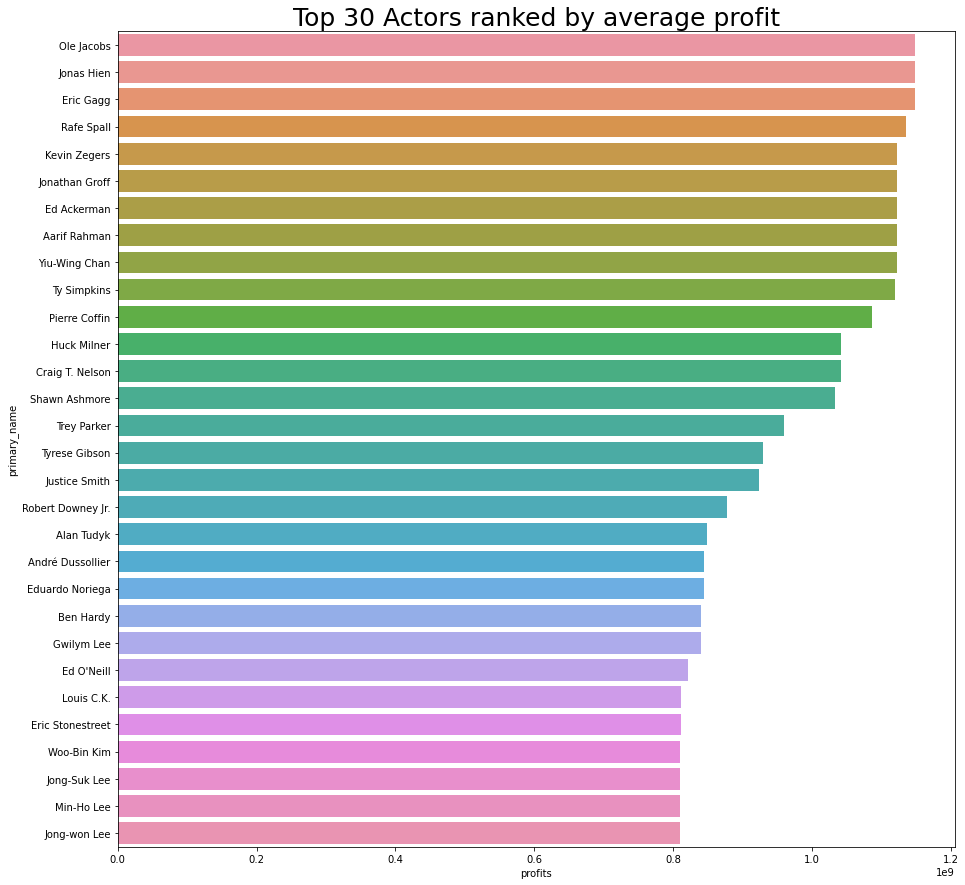

In [76]:
#average profits per director
directors_id_groupby = all_combined[all_combined['category'] == 'actor'].groupby('primary_name').mean().sort_values('profits',ascending=False)
top_20_directors_by_profit = directors_id_groupby.head(30)
top_20_directors_by_profit

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data = top_20_directors_by_profit,x='profits',y=top_20_directors_by_profit.index)
ax.set_title('Top 30 Actors ranked by average profit',fontdict={'fontsize':25})

Text(0.5, 1.0, 'Top 10 Genres ranked by average profit')

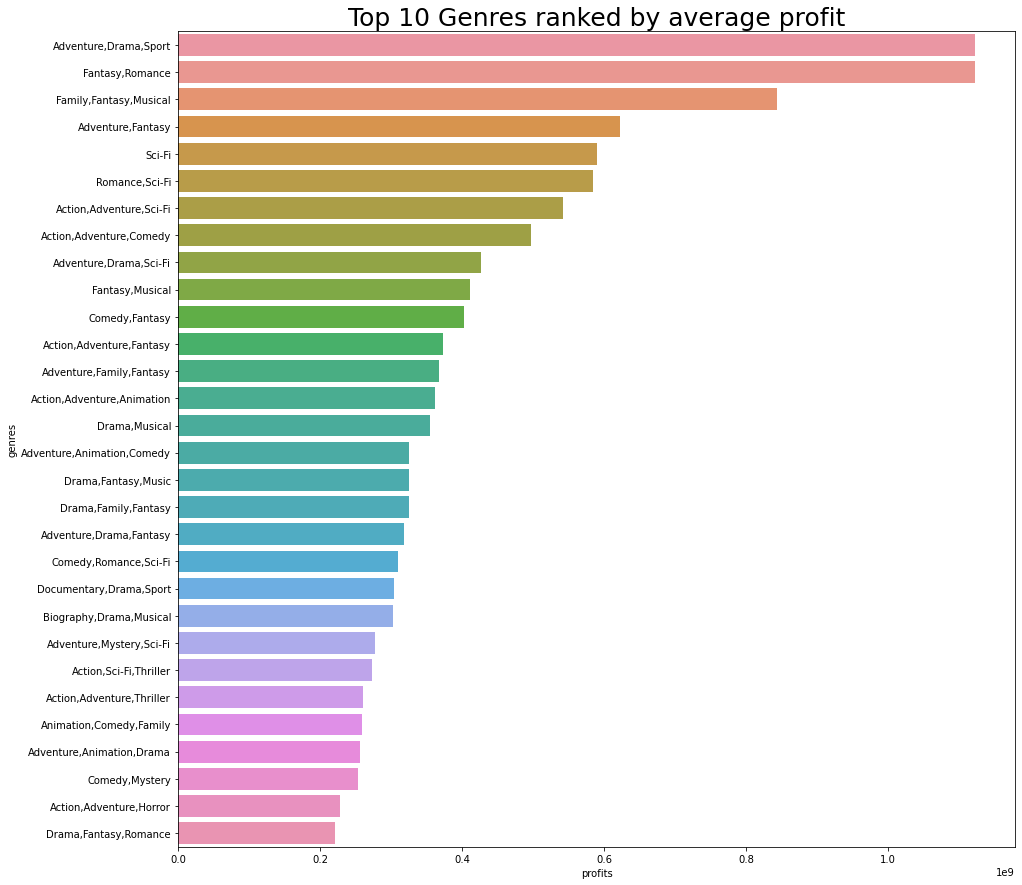

In [77]:
mean_genre_groupby = all_combined.groupby('genres').mean().sort_values('profits',ascending=False)
top_30_genres_average_profits = mean_genre_groupby.head(30)

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data = top_30_genres_average_profits,x='profits',y=top_30_genres_average_profits.index)
ax.set_title('Top 10 Genres ranked by average profit',fontdict={'fontsize':25})


<AxesSubplot:xlabel='production_budget', ylabel='profits'>

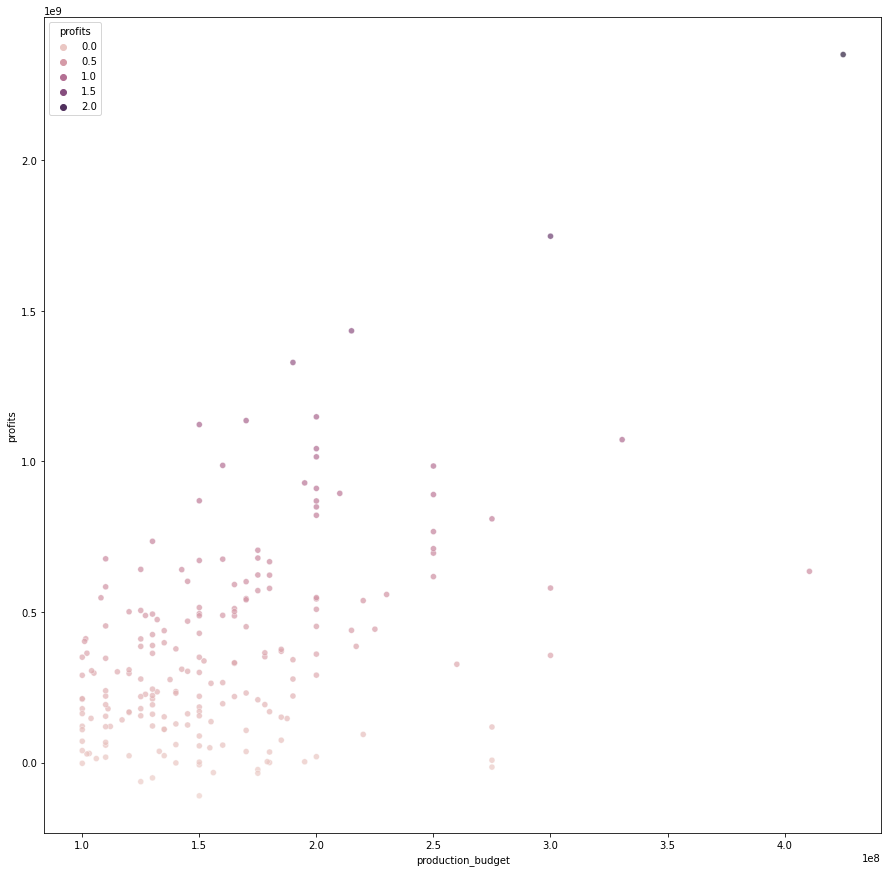

In [78]:
fig,ax = plt.subplots(figsize=(15,15))
movie_budgets_ranking  = all_combined.groupby('title').mean().sort_values('production_budget',ascending=False)
top_200_movie_budgets_ranking = movie_budgets_ranking.head(200)

sns.scatterplot(data=top_200_movie_budgets_ranking,x='production_budget',y='profits',alpha=0.7,hue='profits')


In [79]:
#popularity column should actually be named movie_popularity
# fig,ax = plt.subplots(figsize=(15,15))
# actors_popularity_mean_gross  = all_combined[all_combined['category'] == 'actor'].groupby('primary_name').mean().sort_values('popularity',ascending=False)
# top_200_popular_actors = movie_budgets_ranking.head(200)

# sns.scatterplot(data=top_200_popular_actors,x='popularity',y='worldwide_gross',alpha=0.7,hue='profits')

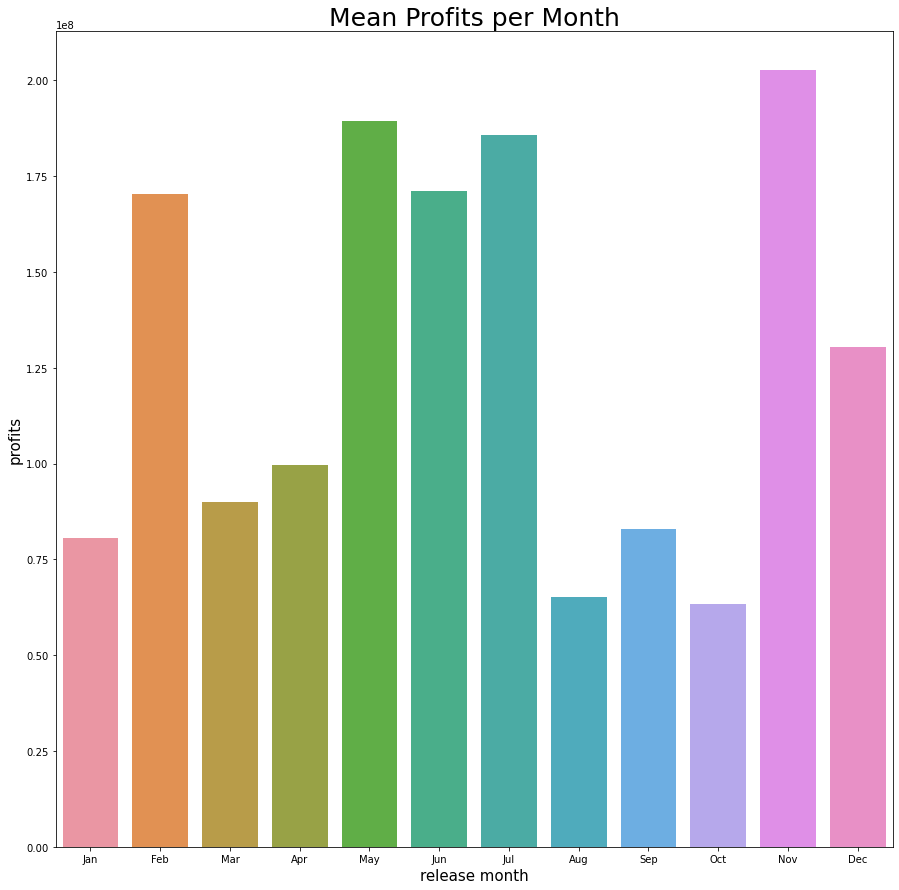

In [80]:
# Monthly Profit Trends (Line Plot)
fig,ax = plt.subplots(figsize=(15,15))
all_combined['release_month'] = pd.to_datetime(all_combined['release_date_x']).dt.month
monthly_profit = all_combined.groupby('release_month')['profits'].mean()
# monthly_profit
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

sns.barplot(x=monthly_profit.index, y=monthly_profit.values)
ax.set_xticklabels(months)
plt.title(label='Mean Profits per Month',fontdict={'fontsize':25})
plt.xlabel(fontdict={'fontsize':15},xlabel='release month')
plt.ylabel(fontdict={'fontsize':15},ylabel='profits');


### Question 1: Do movies with top-rated directors (Group A) generate higher profits than those with lower-rated directors (Group B)?

#### Null Hypothesis: Movies with top-rated directors (Group A) generate equal profit compared to those with lower-rated directors (Group B)?

#### Alternative Hypothesis: Movies with top-rated directors (Group A) generate more profits compared to those with lower-rated directors (Group B)?

   #### Groups:

    #####   Group A: Movies directed by directors in the top 10% by averagerating or profits.

    #####    Group B: Movies directed by others.

    #### Metric: Compare mean profits or worldwide_gross.

    #### Method: Use a two-sample t-test to check if the difference is statistically significant.

In [88]:



directors_top_10 = all_combined[all_combined['category'] == 'director'].groupby('primary_name').mean().sort_values('averagerating',ascending=False)
top_100_directors_average_rating_profits = directors_top_10['profits'].head(100)
# mean_profits_top_50_directors = top_50_directors_average_rating_profits.mean()

not_top_100_directors_average_rating_profits = directors_top_10.tail(834)
random_sample_50_not_top_100 = not_top_100_directors_average_rating_profits['profits'].sample(n=50,random_state=6)


alpha = 0.05
t_statistic, p_value = stats.ttest_ind(top_100_directors_average_rating_profits,random_sample_50_not_top_100)
print('t-stat: ',t_statistic)
print('p_value: ',p_value)

if p_value < alpha:
    print('Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05')
    print('Movies with more popular directors do not generate equal profits')
else:
    print('Failed to reject null hypothesis. Results are not statistically significant')




t-stat:  2.5637634165318914
p_value:  0.011351146206348809
Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05
Movies with more popular directors do not generate equal profits


In [85]:
#the popularity column is for movie popularity.
#change the hypothesis test to check for movie popularity

#organize actors by popularity
#null hypothesis: more popular actors dont make same profits
#alternate: more popular actors make more profits.
movies_ranked_popularity = all_combined[all_combined['category'] == 'actor'].groupby('title').mean().sort_values('popularity',ascending=False)
top_200_popular_movies = movies_ranked_popularity['profits'].head(200)
not_top_200_movies = movies_ranked_popularity.tail(1410)
random_sample_200_movies_not_top_200 = not_top_200_movies['profits'].sample(n=200,random_state=42)

alpha = 0.05
t_statistic, p_value = stats.ttest_ind(top_200_popular_movies,random_sample_200_movies_not_top_200)
print('t-stat: ',t_statistic)
print('p_value: ',p_value)

if p_value < alpha:
    print('Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.')
    print('More popular movies do not make the same profits as less popular movies')
else:
    print('Failed to reject null hypothesis. Results are not statistically significant')


t-stat:  12.536536420391192
p_value:  1.2877422300304936e-30
Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.
More popular movies do not make the same profits as less popular movies


In [86]:
# all_combined[['title','runtime_minutes']].groupby('title').mean().sort_values('runtime_minutes',ascending=True).head(50)

#Question 3: Movies with higher ratings make more profit?

#Null: Movies with higher ratings don't make higher profits?
#alternate: Movies with higher ratings make more profits?


highest_rated_movies = all_combined.groupby('title').mean().sort_values('averagerating',ascending=False)
top_100_rated_movies_profits = highest_rated_movies['profits'].head(100)

not_top_100_movies = highest_rated_movies.tail(894)
sample_not_top_100_movies_profits = not_top_100_movies['profits'].sample(n=100,random_state=42)

alpha = 0.05
t_statistic, p_value = stats.ttest_ind(top_100_rated_movies_profits,sample_not_top_100_movies_profits)
print('t-stat: ',t_statistic)
print('p_value: ',p_value)

if p_value < alpha:
    print('Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.')
    print('More highest-rated movies do not make the same profits as lower-rated movies')
else:
    print('Failed to reject null hypothesis. Results are not statistically significant')


t-stat:  5.198120400069214
p_value:  4.994850179731832e-07
Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.
More highest-rated movies do not make the same profits as lower-rated movies
